# Lyric LLM RAG Project - Harshini Raju
**PART 2 - Process Data and Identify Emotion for songs using Langchain and HuggingFaceHub Chat Model**
<br><br>- Utilise Langchain and HuggingFaceHub Chat models to understand the emotion for the translation of each song.<br>- Save the identifies emotions for each line in lyrics and identify most common emotion for each song.

## Installation

In [ ]:
%pip install --upgrade --quiet  nlpcloud
%pip install -q huggingface_hub

In [10]:
from langchain import HuggingFaceHub, LLMChain
from langchain import PromptTemplate
import json
import os
import google.generativeai as genai
from collections import Counter
import nltk

# Download the Punkt tokenizer for sentence splitting (only need to do this once)
nltk.download('punkt')
nltk.download('words')

from nltk.corpus import words
import pandas as pd
import time
import re

import matplotlib.pyplot as plt
import seaborn as sns

# This is to supress the warning messages (if any) generated in our code
import warnings
warnings.filterwarnings('ignore')

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

# We are using whitegrid style for our seaborn plots. This is like the most basic one
sns.set_style(style = 'whitegrid')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


## API Key for HuggingFaceHub

In [2]:
os.environ["HUGGINGFACE_API_KEY"] = "api key here"
HUGGINGFACE_API_KEY = os.environ["HUGGINGFACE_API_KEY"] 

## Get the input data- JSON of song names and their lyric (translation)

In [3]:
# Load JSON file
with open('song_data.json', 'r') as json_file:
    data = json.load(json_file)

In [97]:
len(data)

212

## Initialise the prompt for the Langchain chat model to utilise for identifying emotions

In [4]:
template='''You analyze the emotions of the text provided. Classify the emotions to happy, sad, love, anger, depressed, fun, comfort, motivation, confident
{text}
'''

prompt = PromptTemplate(template = template,input_variables=["text"])

In [5]:

# initialize Hub LLM
hub_llm = HuggingFaceHub(
        repo_id='google/flan-t5-xxl',
    huggingfacehub_api_token = HUGGINGFACE_API_KEY,
    model_kwargs={'temperature':0.8,
                  'max_length':2048}
)


llm_chain = LLMChain(
    prompt=prompt,
    llm=hub_llm
)

c:\Users\harsh\anaconda3\lib\site-packages\huggingface_hub\utils\_deprecation.py:131: FutureWarning: 'InferenceApi' (from 'huggingface_hub.inference_api') is deprecated and will be removed from version '1.0'. `InferenceApi` client is deprecated in favor of the more feature-complete `InferenceClient`. Check out this guide to learn how to convert your script to use it: https://huggingface.co/docs/huggingface_hub/guides/inference#legacy-inferenceapi-client.
  warnings.warn(warning_message, FutureWarning)


### Functions to pre-process text
- splitting sentences to tokenize the lyrics translation
- clean the text to remove special characters

In [6]:
def split_into_sentences(text):
    sentences = nltk.sent_tokenize(text)
    return sentences

In [7]:
def remove_non_english(text):
    # Define a regular expression pattern to match non-English characters
    non_english_pattern = re.compile(r'[^\x00-\x7F]+')

    # Use the pattern to substitute non-English characters with an empty string
    cleaned_text = non_english_pattern.sub('', text)
    
    return cleaned_text

### Function to idenitfy the most common emotino in each song based on lyric translation

In [10]:
def word_with_maximum_count(word_list):
    # Convert the words to lowercase for case-insensitive counting
    lowercased_words = [word.lower() for word in word_list]
    
    # Use Counter to count occurrences of each word
    word_counts = Counter(lowercased_words)
    
    # Find the word with the maximum count
    max_word = max(word_counts, key=word_counts.get)
    
    return max_word, word_counts[max_word]


In [90]:
song_emotion = {}
emotions1 = {}
lyric_emotion = {}

### Identify Emotions in each line and find the most common emotion per song
<br> Two JSONs are populated here:
- song_emotion => Has the most common emotion for a song (After calculating based on emotion for each line)
- lyric_emotion => JSON that stores the emotion identified in each line of the song

In [92]:
for index, (song, value) in enumerate(data.items()):
    if index > 0:  # Had to manually manage the iteration to accomodate for API Rate Limits 
        print(song)
        result_sentences = split_into_sentences(data[song])

        # Print the result
        for sentence in result_sentences:
            sentence_clean =remove_non_english(sentence)

            if len(sentence_clean)>=1024:
                short_sent = sentence_clean.split("\n")
                for s in short_sent:
                    emotions1[s] =llm_chain.run(s)
            else:
                emotions1[sentence_clean]= llm_chain.run(sentence_clean)
        max_word, max_count = word_with_maximum_count(emotions1)
        song_emotion[song] = max_word
        print(f"The word with the maximum count for {song} is '{max_word}' with count: {max_count}")
        lyric_emotion[song]=emotions1
        time.sleep(200)

voice
do-you
awakening
monster
%eb%b2%84%eb%a0%a4-throw-away
joke
god-rap
rush-feat-krizz-kaliko
life
adrift
i-believe


Save both the JSON 

In [ ]:
# File path
file_path = 'song_emotion.json'

# Load existing data from the file if it exists
try:
    with open(file_path, 'r', encoding='utf-8') as json_file:
        existing_data = json.load(json_file)
except FileNotFoundError:
    # If the file doesn't exist yet, initialize with an empty dictionary
    existing_data = {}

# Update the existing data with the new data
existing_data.update(song_emotion)

# Save the updated dictionary as a JSON file
with open(file_path, 'w', encoding='utf-8') as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=2)

In [95]:
# File path
file_path = 'lyric_emotion.json'

# Load existing data from the file if it exists
try:
    with open(file_path, 'r', encoding='utf-8') as json_file:
        existing_data = json.load(json_file)
except FileNotFoundError:
    # If the file doesn't exist yet, initialize with an empty dictionary
    existing_data = {}

# Update the existing data with the new data
existing_data.update(lyric_emotion)

# Save the updated dictionary as a JSON file
with open(file_path, 'w', encoding='utf-8') as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=2)

In [4]:
# File path
file_path = 'lyric_emotion.json'

# Load existing data from the file if it exists
with open(file_path, 'r', encoding='utf-8') as json_file:
    existing_data = json.load(json_file)
    print(len(existing_data))

209


## Saving the JSON files as CSV

In [5]:
def song_json_to_csv(filename):
    # Load the JSON data
    with open(filename) as f:
        data = json.load(f)

    # Create empty lists to store song names and emotions
    song_names = []
    emotions = []

    # Iterate over the JSON data and extract song names and emotions
    for song_name, emotion in data.items():
        song_names.append(song_name)
        emotions.append(emotion)

    # Create a DataFrame
    df = pd.DataFrame({
        'Song Name': song_names,
        'Emotion': emotions
    })

    # Construct CSV filename
    csv_filename = filename.split(".")[0] + ".csv"

    # Save DataFrame to CSV
    df.to_csv(csv_filename, index=False)

    return df


In [6]:
df_song = song_json_to_csv("song_emotion.json")

# Display the DataFrame
print(df_song.head())
print(df_song.describe())

           Song Name    Emotion
0         black-swan  depressed
1            my-time  depressed
2  louder-than-bombs  depressed
3                ugh      anger
4        inner-child      happy
         Song Name Emotion
count          212     212
unique         212      11
top     black-swan    love
freq             1      48


In [7]:
emotions = df_song['Emotion'].unique()

In [8]:
print(emotions)

['depressed' 'anger' 'happy' 'love' 'comfortable' 'comfort' 'motivation'
 'fun' 'positive' 'sad' 'confident']


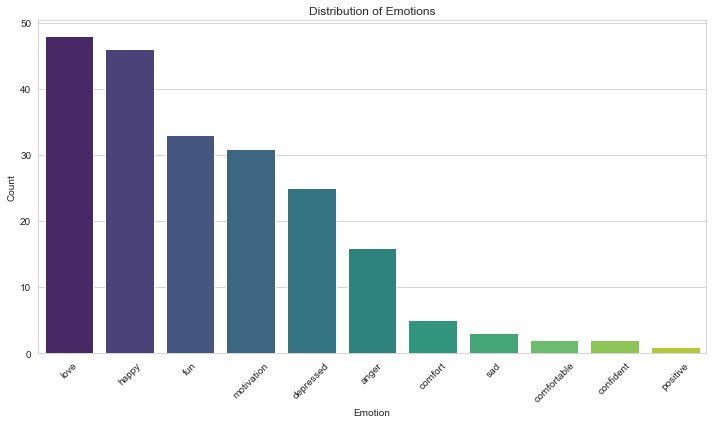

In [11]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df_song['Emotion'].value_counts().index, y=df_song['Emotion'].value_counts(), palette='viridis')
plt.title('Distribution of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
def lyric_json_to_csv(filename):
    # Load the JSON data
    with open(filename) as f:
        data = json.load(f)

    # Create empty lists to store song names, lyric lines, and emotions
    song_names = []
    lyric_lines = []
    emotions = []

    # Iterate over the JSON data and extract song names, lyric lines, and emotions
    for song_name, lines in data.items():
        for line, emotion in lines.items():
            song_names.append(song_name)
            lyric_lines.append(line)
            emotions.append(emotion)

    # Create a DataFrame
    df = pd.DataFrame({
        'Song Name': song_names,
        'Lyric Line': lyric_lines,
        'Emotion': emotions
    })

    csv_filename = filename.split(".")[0] + ".csv"

    df.to_csv(csv_filename, index=False)


    return df

In [14]:
df_lyric = lyric_json_to_csv("lyric_emotion.json")

# Display the DataFrame
print(df_lyric.head())
print(df_lyric.describe())

     Song Name                                         Lyric Line     Emotion
0  born-singer   Original Track: Born Sinner byJ.Cole\nLyrics ...  motivation
1  born-singer                      Im a born singer    (I swear)   confident
2  born-singer  Im a born singer, a bit belated confession (I ...         fun
3  born-singer  A mirage that used to be ever so far awayis in...  motivation
4  born-singer  Im a born singer,perhaps a bit early confessio...   confident
          Song Name                                   Lyric Line Emotion
count        201738                                       201738  201738
unique          209                                         5533     110
top     born-singer  Please click here for inquiries & feedback!    love
freq           2255                                          209   45574


In [15]:
emotions = df_lyric['Emotion'].unique()
print(emotions)

['motivation' 'confident' 'fun' 'happy' 'sad' 'comfortable' 'comfort'
 'anger' 'love' 'depressed' 'sadness' 'loving' 'motivated' 'motivating'
 'fear' 'angry' 'scary' 'confidence' 'very depressed' 'positive'
 'Ive changed' 'I dont know' 'honest' 'got them' 'down' 'joy' 'satisfied'
 'encouraging' 'shy' 'emotion wheel' 'forward' 'excited' 'negative' 'kind'
 'happiness' 'sake' 'depressed, depressed' 'hopeful'
 'this universe did not start right away.' 'perhaps' 'hope' 'compassion'
 'unconfident' 'knowing is more comfortable than not knowing' 'mood'
 'depressive' 'judgment' 'uncategorized' 'need' 'careless' 'confindent'
 'unmotivated' 'stress' 'motivator' 'nervous' 'humor' 'i still love it'
 'helplessly falling' 'good' 'anxiety' 'content'
 'need, depressed, depressed' 'confusion' 'like' 'sympathy' 'music'
 'cheerful' 'emotional' 'more confident' 'optimistic' 'have fun' 'proud'
 '' 'confused' 'calm' '        ' 'trust' 'defensive' 'meaningful'
 'depress' 'origami' 'he comfort' 'lovesad' 'disc

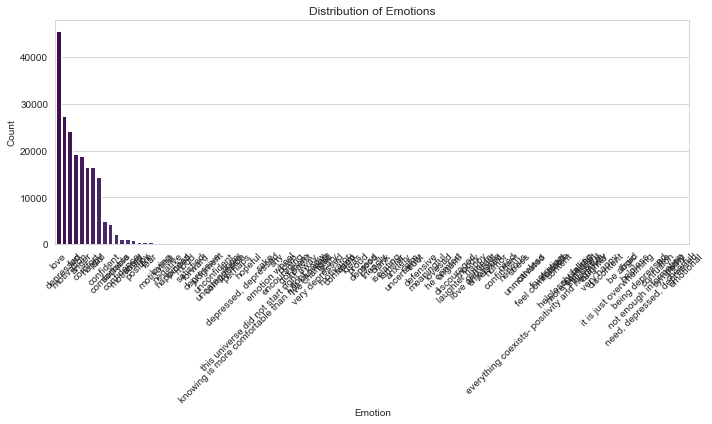

In [16]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df_lyric['Emotion'].value_counts().index, y=df_lyric['Emotion'].value_counts(), palette='viridis')
plt.title('Distribution of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


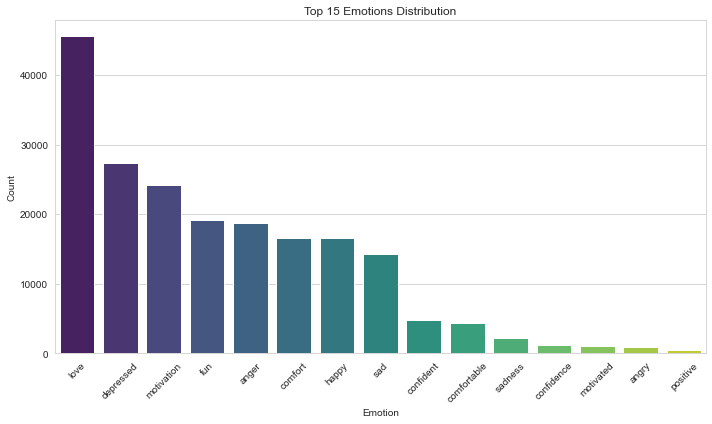

In [19]:
# Get the top 15 emotions by count
top_10_emotions = df_lyric['Emotion'].value_counts().nlargest(15)

# Filter the DataFrame to include only the top 10 emotions
df_top_10 = df_lyric[df_lyric['Emotion'].isin(top_10_emotions.index)]

# Plot the distribution of the top 10 emotions
plt.figure(figsize=(10, 6))
sns.barplot(x=df_top_10['Emotion'].value_counts().index, y=df_top_10['Emotion'].value_counts(), palette='viridis')
plt.title('Top 15 Emotions Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
